In [26]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary
from pymutspec.constants import possible_sbs192, possible_sbs12

In [36]:
data  = []
for d in glob.glob("../data/alisim/spectra_reconstructed_sp/*"):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms192syn_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp/{elabel}/mutspec192.tsv"
    
    if os.path.exists(path_to_gt) and os.path.exists(path_to_rec):
        rec = pd.read_csv(path_to_rec, sep="\t")
        gt = pd.read_csv(path_to_gt, sep="\t")
        spectra = gt[gt.Label == "syn"].groupby("Mut").agg({"ObsNum": np.sum, "ExpNum": np.mean})
        spectra["MutSpec"] = spectra["ObsNum"]  / spectra["ExpNum"]
        spectra["MutSpec"] = spectra["MutSpec"] / spectra["MutSpec"].sum()
        spectra = spectra.merge(
            rec.set_index("Mut"), left_index=True, right_index=True, suffixes=["_gt", "_rec"]).fillna(0.)
        
        cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        mdl, tree, aln, _, replica = elabel.split("_")
        data.append((mdl, tree, aln, replica, cossim, eucdist))
    else:
        print(elabel, "error")

In [48]:
sims = pd.DataFrame(data, columns=["mdl", "tree", "aln", "replica", "cossim", "eucdist"])
sims["Condition"] = sims.mdl + "_T" + sims.tree + "_" + sims.aln

In [49]:
sims

,mdl,tree,aln,replica,cossim,eucdist,Condition
0,12.12,1000,rnd,replica77,0.998374,0.006774,12.12_T1000_rnd
1,gtr,1000,cytb,replica30,0.975046,0.100541,gtr_T1000_cytb
2,gtr,1000,rnd,replica37,0.999142,0.043168,gtr_T1000_rnd
3,gtr,1000,rnd,replica1,0.999434,0.006063,gtr_T1000_rnd
4,12.12,1000,cytb,replica43,0.385368,0.219688,12.12_T1000_cytb
...,...,...,...,...,...,...,...
779,gtr,1000,cytb,replica33,0.995943,0.013914,gtr_T1000_cytb
780,12.12,1000,cytb,replica25,0.999656,0.003593,12.12_T1000_cytb
781,gtr,100,cytb,replica7,0.243567,0.482439,gtr_T100_cytb
782,12.12,1000,cytb,replica49,0.999819,0.006655,12.12_T1000_cytb


In [60]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.cossim > cutoff
sims.groupby("Condition")[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.95,False,True
Condition,,
12.12_T1000_cytb,16,84
12.12_T1000_rnd,7,93
12.12_T100_cytb,9,91
12.12_T100_rnd,4,90
gtr_T1000_cytb,11,89
gtr_T1000_rnd,7,93
gtr_T100_cytb,6,94
gtr_T100_rnd,1,89


In [61]:
cutoff = 0.85
sims[f"cossim > {cutoff}"] = sims.cossim > cutoff
sims.groupby("Condition")[f"cossim > {cutoff}"].value_counts().unstack()

cossim > 0.85,False,True
Condition,,
12.12_T1000_cytb,11,89
12.12_T1000_rnd,6,94
12.12_T100_cytb,9,91
12.12_T100_rnd,3,91
gtr_T1000_cytb,5,95
gtr_T1000_rnd,6,94
gtr_T100_cytb,6,94
gtr_T100_rnd,1,89


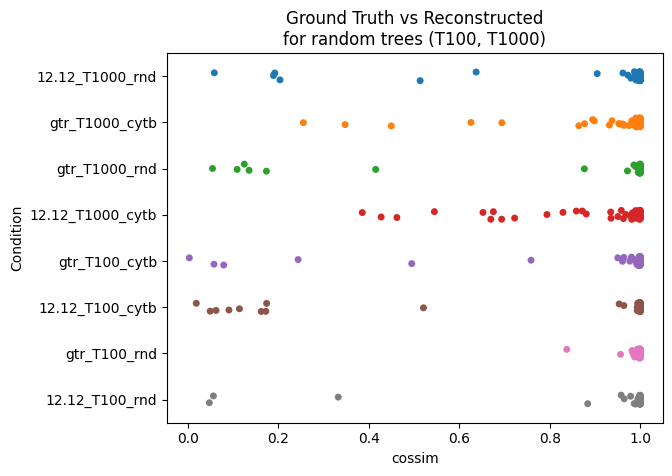

In [68]:
sns.stripplot(data=sims, y="Condition", x="cossim")
plt.title("Ground Truth vs Reconstructed\nfor random trees (T100, T1000)")
plt.show()

In [72]:
sims[sims.cossim < 0.2]

,mdl,tree,aln,replica,cossim,eucdist,Condition,Piu,cossim > 0.95,cossim > 0.85
96,12.12,100,cytb,replica87,0.018313,0.931696,12.12_T100_cytb,False,False,False
115,12.12,100,cytb,replica24,0.161921,0.629476,12.12_T100_cytb,False,False,False
117,12.12,100,cytb,replica88,0.172099,0.674382,12.12_T100_cytb,False,False,False
123,gtr,1000,rnd,replica8,0.173404,0.556516,gtr_T1000_rnd,False,False,False
147,gtr,1000,rnd,replica96,0.054260,0.745941,gtr_T1000_rnd,False,False,False
165,gtr,100,cytb,replica51,0.057547,0.811606,gtr_T100_cytb,False,False,False
193,12.12,1000,rnd,replica99,0.058245,0.717862,12.12_T1000_rnd,False,False,False
194,gtr,1000,rnd,replica53,0.135135,0.777992,gtr_T1000_rnd,False,False,False
203,12.12,100,cytb,replica11,0.113845,0.733759,12.12_T100_cytb,False,False,False
265,12.12,100,cytb,replica8,0.090567,0.706126,12.12_T100_cytb,False,False,False
